In [136]:
import random
import matplotlib.pyplot as plt
import numpy as np
import itertools
from docplex.mp.model import Model

Définitions des paramètres 

In [137]:
capacité = 100 # capacité de la camionnette du marchand de poisson
nclients = 15 # nombre de clients 
nmagasins = 3 # nombre d'endroits possibles pour le magasin

In [138]:
random.seed(49) # fixer le seed du random pour toujours avoir les mêmes données 
N = [int(i) for i in range(nmagasins, nclients+nmagasins)] # numéro des clients (nom)
V = [0,1] + N # noeuds = clients / noeud 0 = magasin
demandes = {i:random.randint(5,25) for i in N} # génération des quantités pour chaque client 
clients = [(random.randint(0,30),random.randint(0,30)) for _ in range(nclients)] # génération des coordonnées aléatoires des clients 
magasins = [(random.randint(0,30), random.randint(0,30)) for _ in range(nmagasins)] # génération des coordonnées aléatoires des magasins

In [139]:
xc = [0,0] + [d[0] for d in clients] # axe x clients 
yc = [0,0] + [d[1] for d in clients] # axe y clients 
xm = [d[0] for d in magasins] # axe x magasins 
ym = [d[1] for d in magasins] # axe y magasin

In [140]:
def add_magasin(xm,ym,cx,cy):
    for i in range(len(xm)):
        cx[i],cy[i] = xm[i],ym[i]
    return cx,cy

Plot des emplacements des clients (annoté de taille de demande) et des endroits possible pour les magasins

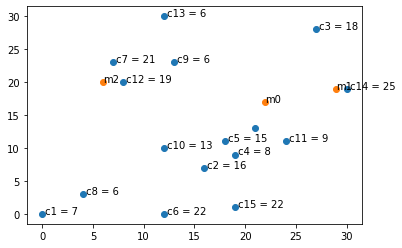

In [141]:
fig, ax = plt.subplots() 
ax.scatter(xc[1:],yc[1:])
ax.scatter(xm,ym)
for i, q in enumerate(demandes.values()):
    ax.annotate(f' c{i+1} = {q}', (xc[i+1],yc[i+1]))
for i in range(nmagasins):
    ax.annotate(f'm{i}', (xm[i],ym[i]))
plt.show()

In [142]:
def ModelInit(arcs, capacité, demandes, distances, N):
    model = Model('CVRP')
    x = model.binary_var_dict(arcs, name = 'x') # variable binaire pour les arcs -> 0 ou 1 en fonction de si on le prend ou pas
    u = model.continuous_var_dict(N, ub = capacité, name = 'u') # ub = upperbound = capacité camionnette
    print(distances)
    model.minimize(model.sum(distances[i,j]*x[i,j] for i,j in arcs)) # fct objectif = minimiser la distance entre les arcs qui sont pris
    model.add_constraints(model.sum(x[i,j] for j in V if j!=i) == 1 for i in N) # graphe connexe, tous les arcs doivent être liés
    model.add_constraints(model.sum(x[i,j] for i in V if i!=j) == 1 for j in N)
    model.add_indicator_constraints(model.indicator_constraint(x[i, j], u[i]+demandes[j] == u[j]) for i, j in arcs if i != 0 and j != 0)
    model.add_constraints(u[i] >= demandes[i] for i in N)
    model.parameters.timelimit = 60
    return model
  

In [143]:
def ModelInit2(arcs, capacité, demandes, distances, N, nmagasins):
    model = Model('CVRP')
    x = model.binary_var_dict(arcs, name = 'x') # variable binaire pour les arcs -> 0 ou 1 en fonction de si on le prend ou pas
    u = model.continuous_var_dict(N, ub = capacité, name = 'u') # ub = upperbound = capacité camionnette
    model.minimize(model.sum(distances[i,j]*x[i,j] for i,j in arcs)) # fct objectif = minimiser la distance entre les arcs qui sont pris
    model.add_constraints(model.sum(x[i,j] for j in V if j!=i) == 1 for i in N) # graphe connexe, tous les arcs doivent être liés
    model.add_constraints(model.sum(x[i,j] for i in V if i!=j) == 1 for j in N)
    model.add_indicator_constraints(model.indicator_constraint(x[i, j], u[i]+demandes[j] == u[j]) for i, j in arcs if (i not in range(nmagasins) and j not in range(nmagasins)))
    model.add_constraints(u[i] >= demandes[i] for i in N)
    # model.parameters.timelimit = 60
    return model
  

In [144]:
def solver(model):
    return model.solve(log_output = False)

Définition des arcs d'un noeud i à un noeud j et calcul de distance pour chaque arc

In [145]:
best_value = 10**10
best_magasin = None
best_solution = None

xtot, ytot = add_magasin(xm,ym,xc,yc)

arcs = [(i,j) for i in V for j in V if (i not in range(nmagasins) or j not in range(nmagasins))]
dists = {(i,j): np.hypot(xtot[i]-xtot[j],ytot[i]-ytot[j]) for i,j in arcs}

model2 = ModelInit2(arcs, capacité, demandes, dists, N, nmagasins)
solution2 = solver(model2)
value = solution2.objective_value
print(f'La plus petite distance à parcourir est {value}' )

[(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (3, 0), (3, 1), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (4, 0), (4, 1), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (5, 0), (5, 1), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (6, 0), (6, 1), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (7, 0), (7, 1), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (7, 16), (7, 17), (8, 0), (8, 1), (8, 3),

IndexError: list index out of range

In [ ]:
"""best_value = 10**10
best_magasin = None
best_solution = None
for magasin in range(nmagasins):
    xtot, ytot = add_magasin(xm[magasin],ym[magasin],xc,yc)
    arcs = [(i,j) for i in V for j in V if i!=j]
    distances = {(i,j): np.hypot(xtot[i]-xtot[j],ytot[i]-ytot[j]) for i,j in arcs}
    model = ModelInit(arcs, capacité, demandes, distances, N)
    solution = solver(model)
    value = solution.objective_value
    if value < best_value:
        best_value = value 
        best_magasin = magasin
        best_solution = solution
print(f'La plus petite distance à parcourir est {best_value}')
print(f'Le numéro du meilleur emplacement pour le magasin est {best_magasin}')"""

"best_value = 10**10\nbest_magasin = None\nbest_solution = None\nfor magasin in range(nmagasins):\n    xtot, ytot = add_magasin(xm[magasin],ym[magasin],xc,yc)\n    arcs = [(i,j) for i in V for j in V if i!=j]\n    distances = {(i,j): np.hypot(xtot[i]-xtot[j],ytot[i]-ytot[j]) for i,j in arcs}\n    model = ModelInit(arcs, capacité, demandes, distances, N)\n    solution = solver(model)\n    value = solution.objective_value\n    if value < best_value:\n        best_value = value \n        best_magasin = magasin\n        best_solution = solution\nprint(f'La plus petite distance à parcourir est {best_value}')\nprint(f'Le numéro du meilleur emplacement pour le magasin est {best_magasin}')"

In [ ]:
arcs_actifs = []
for val in (model2.iter_binary_vars()):
    if val.solution_value > 0.95:
        v = val.name.split('_')
        arcs_actifs.append((int(v[1]),int(v[2])))

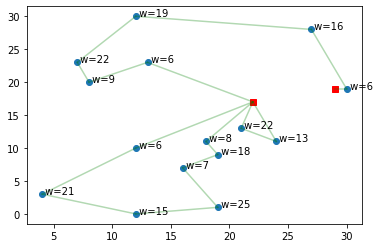

In [ ]:
fig, ax = plt.subplots() 
ax.scatter(xc[nmagasins:],yc[nmagasins:]) # affichage des clients  
for i in N:
    plt.annotate(f' w={demandes[i]}', (xc[i], yc[i]))
for i in range(nmagasins):
    xc[i],yc[i] = xm[i],ym[i]
    plt.plot(xm[i],ym[i], c='r', marker='s') # affichage des magasins
for i,j in arcs_actifs:
     plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', alpha=0.3)
plt.show()